# A bit of introspection

In this script, we explore what's happening inside a CNN classifier.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import copy
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

## Dataset and model

We use the MNIST dataset (we only need the training set here, and we use a larger subset of the data). We also provide a pretrained CNN classifier (same architecture as in the previous lab).

In [3]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset (we only need the training set for this script)
train_data = datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset
len_dataset = 2000
train_data = Subset(train_data, torch.arange(len_dataset))

# Create dataloader (we set shuffle=False since there is no training involved)
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [4]:
# Model definition
class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*num_channels2, num_classes)
    
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out


# Instanciate the model
num_channels1 = 16
num_channels2 = 32
model = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)

# Load the pretrained model's parameters
model.load_state_dict(torch.load('model_cnn_classif_introspection.pt'))

# Place the model in eval mode
model.eval()

CNNClassif_bnorm(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_layer): Linear(in_features=1568, out_features=10, bias=True)
)

## Vizualizing feature maps

Let's visualize the feature maps to have a rough understanding of what has been computed through the CNN layers.

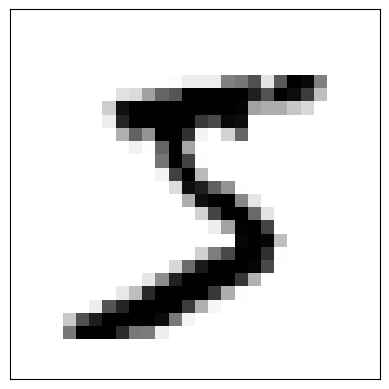

In [5]:
# Retrieve a batch of images
image_batch_example = next(iter(train_dataloader))[0]

# Retrieve the first image in the batch
image_example = image_batch_example[0].squeeze()

# Plot the image
plt.figure()
plt.imshow(image_example, cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

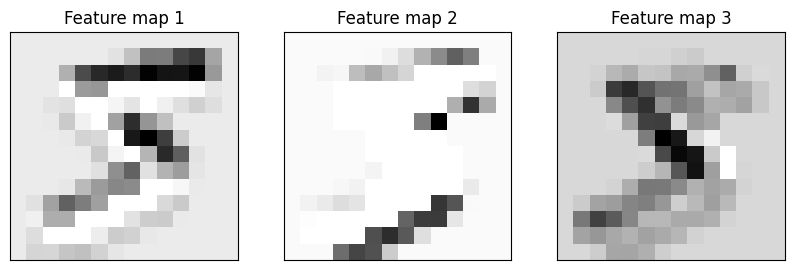

In [6]:
# Compute the output of the first convolution layer
with torch.no_grad():
    out_conv1 = model.cnn_layer1(image_batch_example)

# Get the feature maps corresponding to the first image in the batch
features_maps1 = out_conv1[0]

# Plot the first 3 feature maps
plt.figure(figsize = (10, 6))
for ic in range(3):
    plt.subplot(1, 3, ic+1)
    plt.imshow(features_maps1[ic,:], cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Feature map ' + str(ic+1))
plt.show()

<span style="color:red">**Exercice 1**</span> Compute the output `out_conv2` of the second convolution layer from `out_conv1`. Get the feature maps that corresponds to the first image in the batch, and plot the first 3 feature maps (as above).

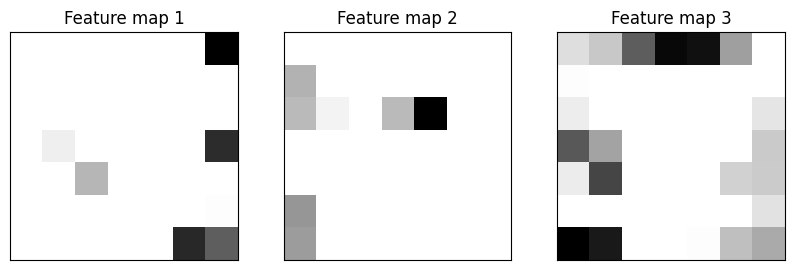

In [7]:
with torch.no_grad():
    out_conv2 = model.cnn_layer2(out_conv1)  # the second convolution layer

# Get the feature maps
features_maps2 = out_conv2[0]

# Plot the first 3 feature maps
plt.figure(figsize=(10, 6))
for ic in range(3):
    plt.subplot(1, 3, ic + 1)
    plt.imshow(features_maps2[ic].cpu().numpy(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Feature map ' + str(ic + 1))
plt.show()

You should observe that the feature maps from the second layer are more abstract and less interpretable than after the first layer. However, even though this lack of interpretability is a major drawback of (deep) neural networks, we can still partly analyze their behavior.

## t-SNE

For classification tasks, we expect that as we go deeper inside the network, the classes becomes more spread apart from each other. Indeed, that's precisely what they are trained for: more distinct classes / clusters are subsequently easier to classify, so the first layers of the network transform the data such that it become grouped in clusters.
 
[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is an algorithm that allows to vizualize high-dimensional data (either raw images or features maps). It projects the data into a low-dimensional space, usually 2D (or 3D), and the resulting projected data is called *t-SNE embeddings*. These embeddings can be easily plotted in 2D (or 3D), and they allow to see how data samples from different classes are distributed.

In mathematical terms, consider we have a set of data points $\mathbf{x}_i \in \mathbb{R}^N$: for instance, $\mathbf{x}_i$ can be a (vectorized) image or a set of (vectorized) feature maps inside a network. It's difficult to visualize these data points directly because $N$ is usually very large. Therefore, the goal of the t-SNE algorithm is to calculate low-dimension embeddings $\mathbf{y}_i \in \mathbb{R}^2$ (or $\mathbb{R}^3$), such that if two points $\mathbf{x}_i$ and $\mathbf{x}_j$ are close/similar, then the corresponding embeddings $\mathbf{y}_i$ and $\mathbf{y}_j$ will be close/similar as well. As a result, we can easily plot the embeddings $\mathbf{y}_i$ in 2D (or 3D), and visualize the similar data points, see if there are some noticeable clusters, etc.

### Input images

To begin with, let us compute the t-SNE embeddings from the input images of our dataset: this will allow us to vizualize how similar images are. To that end, we need to collect all the images (as well as labels), stack them into one large tensor, and vectorize each data point.

In [8]:
# Initizalize lists to collect images and labels
all_images, all_labels = [], []

# Iterate over the dataloader to collect the data
model.eval()
with torch.no_grad():
    for images, labels in train_dataloader:
        # no particular processing to do here, just append the current batch data (images and labels)
        all_images.append(images)
        all_labels.append(labels)

# transform the lists into torch tensors, and print their shape
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
print('Size of the tensor containing all input images:', all_images.shape)
print('Size of the tensor containing all labels:', all_labels.shape)

# vectorize the images
all_images = all_images.reshape(all_images.shape[0], -1)
print('Size of the tensor containing all vectorized input images:', all_images.shape)

# convert these tensors back to numpy (needed for computing t-SNE, and plot)
all_images = all_images.numpy()
all_labels = all_labels.numpy()

Size of the tensor containing all input images: torch.Size([2000, 1, 28, 28])
Size of the tensor containing all labels: torch.Size([2000])
Size of the tensor containing all vectorized input images: torch.Size([2000, 784])


In [9]:
# Compute t-SNE embeddings from the set of vectorized images
images_TSNE = TSNE(n_components=2, init='pca').fit_transform(all_images)
print('Size TSNE embeddings (input images):', images_TSNE.shape)

Size TSNE embeddings (input images): (2000, 2)


In [10]:
# We provide here a function for displaying the t-SNE embeddings 
def plot_tsne_embeddings(X, y, title):
    
    #y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (5,5))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(int(y[i])),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

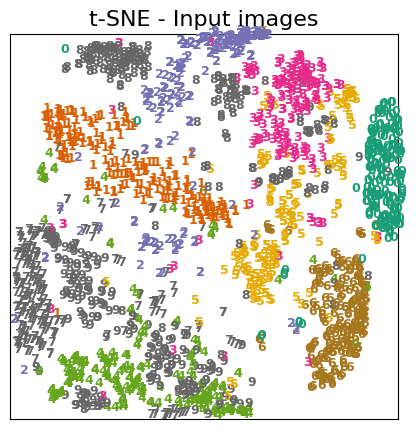

In [11]:
# Apply this function to the input images after TSNE
plot_tsne_embeddings(images_TSNE, all_labels, 'Input images')

We can see above that the data samples corresponding to input images are roughly organized into categories (or *clusters*). However, there is some overlap between classes, which is why a basic classifier operating on raw images might not work very well.

### Inside the network

The CNN classifier learns to transform the input data by computing feature maps that are better for classification. Then, we expect these feature maps to form more distinct clusters in terms of t-SNE embeddings. Let's compute the t-SNE embeddings corresponding to the feature maps of both convolution layers, starting with the first one.

In [12]:
# TO DO: Collect the feature maps after the first convolution layer.
# The overall process is similar as what we did above with the input images:
# - initialize an empty list to store the feature maps
# - iterate over the dataloader to compute the feature maps (use the provided model) and append them to the list
# - cat the list into a large tensor, vectorize the feature maps, and display the tensor's size
# - convert it back to numpy
all_features1, all_labels = [], []
model.eval()

with torch.no_grad():
    for images, labels in train_dataloader:
        features1 = model.cnn_layer1(images)
        all_features1.append(features1)  # store the feature
        all_labels.append(labels)

# cat the list into a large tensor, vectorize the feature maps, and display the tensor's size
all_features1 = torch.cat(all_features1, dim=0)
all_labels = torch.cat(all_labels, dim=0)
print('Size of the tensor cont all features after conv layer 1:', all_features1.shape)
print('Size of the tensor cont all labels:', all_labels.shape)

all_features1 = all_features1.reshape(all_features1.shape[0], -1)
print('Size of the tensor cont all vectorized features after conv layer 1:', all_features1.shape)

# convert tensors to numpy arrays
all_features1 = all_features1.numpy()
all_labels = all_labels.numpy()

Size of the tensor cont all features after conv layer 1: torch.Size([2000, 16, 14, 14])
Size of the tensor cont all labels: torch.Size([2000])
Size of the tensor cont all vectorized features after conv layer 1: torch.Size([2000, 3136])


Size of t-SNE embeddings (conv layer 1 features): (2000, 2)


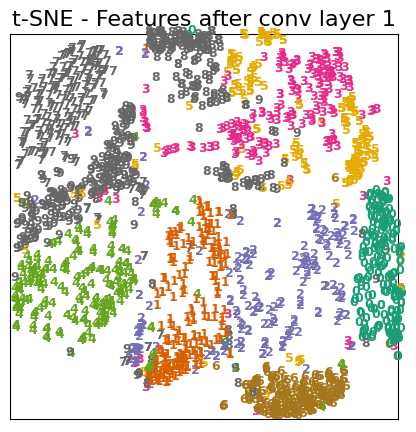

In [13]:
# TO DO: Compute t-SNE embeddings from these feature maps, and plot them
features1_TSNE = TSNE(n_components=2, init='pca').fit_transform(all_features1)
print('Size of t-SNE embeddings (conv layer 1 features):', features1_TSNE.shape)

plot_tsne_embeddings(features1_TSNE, all_labels, 'Features after conv layer 1')

<span style="color:red">**Exercice 2**</span> Following what you just did above, do the same for the output of the second convolutional layer: get the feature maps, vectorize these, compute the t-SNE embeddings, and plot them. What do you observe by comparing the t-SNE embeddings from the input images, output of the 1st layer, and output of the 2nd layer?

In [18]:
all_features2, all_labels2 = [], []
model.eval()

with torch.no_grad():
    for images, labels in train_dataloader:
        # the feature maps after the 2nd conv layer
        features = model.cnn_layer1(images)
        features2 = model.cnn_layer2(features)
        all_features2.append(features2)
        all_labels2.append(labels)

all_features2 = torch.cat(all_features2, dim=0)
all_labels2 = torch.cat(all_labels2, dim=0)
print('Size of the tensor cont all features after conv layer 2:', all_features2.shape)
print('Size of the tensor cont all labels:', all_labels2.shape)

all_features2 = all_features2.reshape(all_features2.shape[0], -1)
print('Size of the tensor cont all vectorized features after conv layer 2:', all_features2.shape)

all_features2 = all_features2.numpy()
all_labels2 = all_labels2.numpy()

Size of the tensor cont all features after conv layer 2: torch.Size([2000, 32, 7, 7])
Size of the tensor cont all labels: torch.Size([2000])
Size of the tensor cont all vectorized features after conv layer 2: torch.Size([2000, 1568])


In [19]:
# Compute t-SNE embeddings from these feature maps
features2_TSNE = TSNE(n_components=2, init='pca').fit_transform(all_features2)
print('Size of t-SNE embeddings (conv layer 2 features):', features2_TSNE.shape)

Size of t-SNE embeddings (conv layer 2 features): (2000, 2)


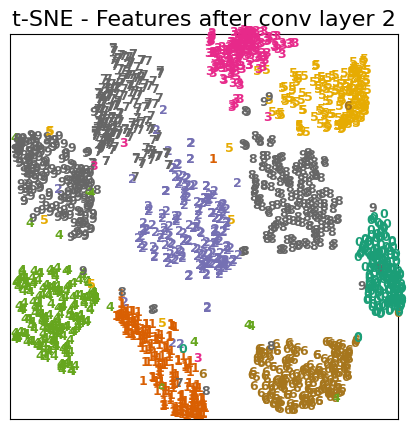

In [20]:
plot_tsne_embeddings(features2_TSNE, all_labels, 'Features after conv layer 2')

When comparing the t-SNE embeddings, we see that the features become more grouped and separated after each layer. 
After the first layer, some classes are forming groups, but there is still some mixing. By the second layer, the groups are much clearer and more separated. The network is learning to tell the features apart better as it goes deeper.